This was created by Donna Faith Go.

# LSTM Trading
In this notebook, I will implement an LSTM model using pyTorch on a randomly generated portfolio from the S&P 500.

In [1]:
import sys
!{sys.executable} -m pip install -qq -r requirements.txt

In [27]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# data gathering
import yfinance as yf

# LSTM neural network 
import torch
import torch.nn as nn

# comparing metrics
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error
)

# webscraping
import requests
from bs4 import BeautifulSoup
import time

# for portfolio generation
from scipy.optimize import minimize
import portfolio

# for lstm
from typing import Tuple
import copy
from tqdm import tqdm

# standardizing
from sklearn.preprocessing import StandardScaler

# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Gathering

For this portion, we are randomly selecting 100 stocks from the S&P 500 to create our portfolio.
The size of 100 was chosen because we want a diverse portfolio.
Furthermore, we also scraped the GSPC stock price because it is the ticker symbol for the S&P 500.
Usually, this is used as a benchmark for the overall US stock market to determine how well a portfolio or a trading strategy is doing.

In [3]:
# getting the stock tickers
headers = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
        '(KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    )
}

response = requests.get(
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
    headers=headers
)
response.raise_for_status()
tables = pd.read_html(response.text)

if len(tables) > 0:
    stocks_df = tables[0]

# randomly selecting 30 stocks
random_stocks = stocks_df['Symbol'].sample(n=100, random_state=42)

In [4]:
# getting closing prices for the 30 stocks with batching
start_date = '2019-01-01'
end_date = '2025-01-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     random_stocks.tolist(), 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/closing prices.pkl')

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     ['^GSPC'], 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/gspc prices.pkl')

Note: The code above takes around 5 minutes to run. 

Here, I tried to pull a lot of data (tried four years instead of three) so that the neural network can capture the hidden patterns in the dataset better.

In [5]:
# opening pkl file
filename = r'data/closing prices.pkl'
with open(filename, 'rb') as f: 
    closing_df = pickle.load(f)
    closing_df.index = pd.to_datetime(closing_df.index)

# getting s&p 500 data
filename = r'data/gspc prices.pkl'
with open(filename, 'rb') as f: 
    gspc_df = pickle.load(f)
    gspc_df.index = pd.to_datetime(gspc_df.index)
gspc_df.rename(columns={'^GSPC': 'GSPC'}, inplace=True)

## Portfolio Generation

Usually, assigning weights yearly for the firms in your portfolio would make more sense.
Patterns in firms change as they have to account for new external factors every year such as shifting market conditions, competition from other firms, and more. 
By changing the weights annually, we are able to incorporate recent financial performance and adjust for any structural changes in the companies.

To make things simple, I will use the Markowitz Portfolio Optimization model to assign weights to the different stocks.
Here, the best portfolios were chosen based on their Sharpe ratio.
For context, the Sharpe Ratio measures an investment's risk-adjusted return. 
It indicates how much extra return you get for the extra volatility (risk) you take on compared to a risk-free asset.

In [6]:
cols = [
    'year', 'expected return', 'volatility', 'sharpe ratio'
]
results_df = pd.DataFrame(columns=cols)

# # generate portfolios
# years = ['2019', '2020', '2021', '2022', '2023', '2024']
# for year in years:
#     p = portfolio.generate_portfolio(
#         closing_df.loc[year],
#         year
#     )
#     weights, results, stocks = p.get_portfolio()
#     ef_portfolio = pd.Series(weights, index=stocks)
#     ef_portfolio.to_pickle(
#         f'portfolios/{year} ef portfolio.pkl'
#     )
#     results_df.loc[len(results_df)] = results

# # display performance of portfolios
# display(results_df)

For context, the Sharpe ratio of the S&P 500 usually falls between 0.80 and 1.46.

## EDA I

In [7]:
# get historical data
historical_data = closing_df.copy()

# check nulls
if any(historical_data.isnull().sum() > 1):
    print('There are still some nulls for historical data.')
else:
    print('There are no more nulls for historical data.')

There are still some nulls for historical data.


Since there are some columns with nulls, we are going to have to drop them. 

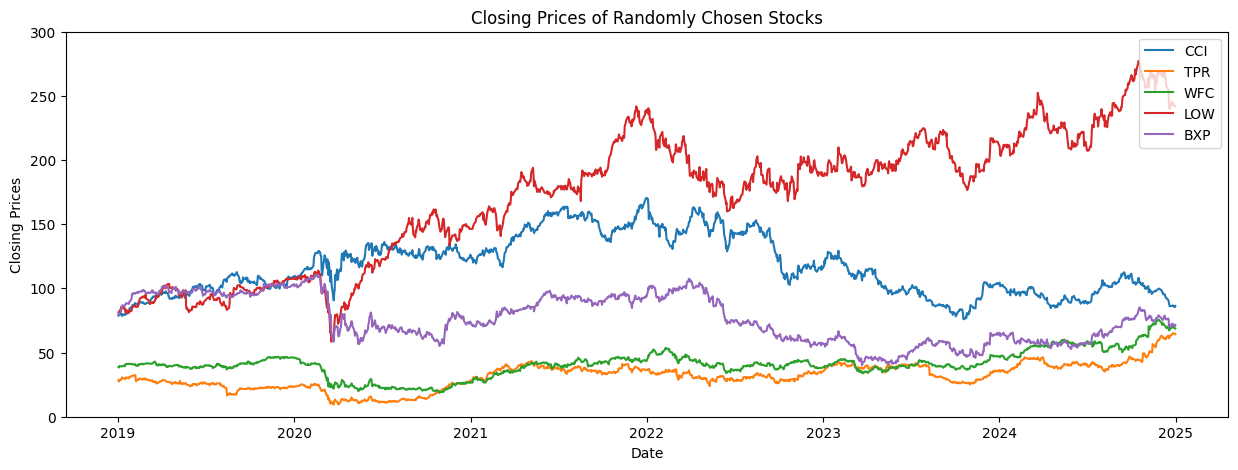

In [8]:
# randomly selecting stocks
np.random.seed(42)
random_stocks = np.random.choice(historical_data.columns, 5)

# plotting the closing prices of random stocks
plt.figure(figsize=(15, 5))
for stock in random_stocks:
    plt.plot(historical_data[stock], label=stock)
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.ylim(0, 300)
plt.title('Closing Prices of Randomly Chosen Stocks')
plt.show()

Based on the figure above, we can see that there are significant differences in the closing stock prices. 
We'll have to turn the data into log returns or standardize the data in order to make meaningful comparisons.
This transformation will also make the time series more stationary which makes it easier for machine learning models to forecast price.

## Feature Engineering

In [9]:
# dropping stocks with null columns
historical_data = historical_data.dropna(axis=1, how='any')

# get log returns
log_returns = historical_data.pct_change().dropna(how='all')
print(f'There are a total of {len(log_returns.columns)} remaining after feature engineering.')

# standardize data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(historical_data.values)
standardized_df = pd.DataFrame(
    standardized_data, columns=historical_data.columns, index=historical_data.index
)

# check nulls for log returns
if any(log_returns.isnull().sum() > 1):
    print('There are still some nulls for log returns.')
else:
    print('There are no more nulls for log returns.')

# check nulls for standardized closing prices
if any(standardized_df.isnull().sum() > 1):
    print('There are still some nulls for standardized data.')
else:
    print('There are no more nulls for standardized data.')

There are a total of 92 remaining after feature engineering.
There are no more nulls for log returns.
There are no more nulls for standardized data.


When training the model, we want to make sure that it is not handling any null data because this might affect how well it can forecast.

## EDA II

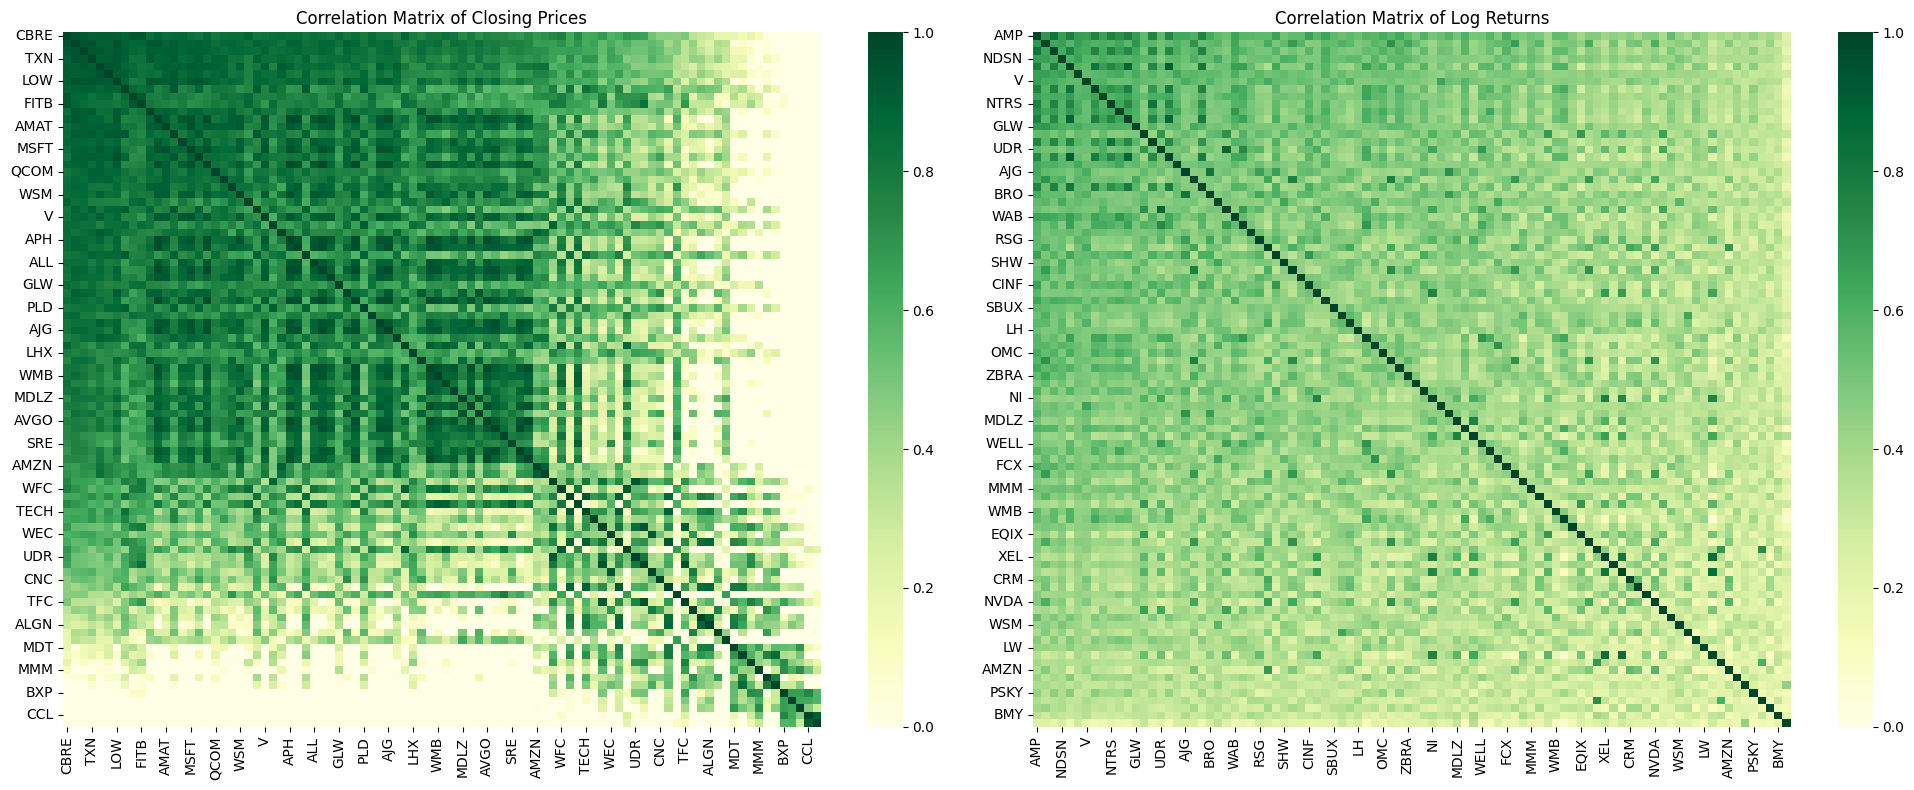

In [10]:
# compute correlation matrices
correl_prices = historical_data.corr()
order_prices = correl_prices.mean().sort_values(ascending=False).index
correl_prices_sorted = correl_prices.loc[order_prices, order_prices]

correl_returns = log_returns.corr()
order_returns = correl_returns.mean().sort_values(ascending=False).index
correl_returns_sorted = correl_returns.loc[order_returns, order_returns]

# plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(
    correl_prices_sorted, cmap='YlGn', fmt=".2f", vmin=0, vmax=1, ax=axes[0]
)
axes[0].set_title('Correlation Matrix of Closing Prices')

sns.heatmap(
    correl_returns_sorted, cmap='YlGn', fmt=".2f", vmin=0, vmax=1, ax=axes[1]
)
axes[1].set_title('Correlation Matrix of Log Returns')

plt.tight_layout()
plt.show()

**Disclaimer**: The heatmap is limited to the values between 0 and 1 inclusive because there are little to no negative correlations.

The heatmap of the correlation matrix for log returns shows that a lot of the stocks are closer to weak to negligible correlation.
This entails that we have a diverse portfolio which is ideal for mitigating unsystematic risk within our trading strategy.
However, the strong correlations in the closing prices could indicate that all of them could be influenced by the same long-term trends or macroeconomic factors.

In short, the portfolio is more robust to short-term risks compared to long-term risks. If the trading strategy we want to use is daily, then this is beneficial for us.

## LSTM NN Implementation

First, we have to define the functions to be used by the machine learning mode. 
The functions for the splitting the time series with a lookback window is from Professor Ethan Robert A. Casin's lectures for our Machine Learning II course.

In [11]:
# train test split with lookback
def train_test_split(data: pd.Series, lookback: int = 12, test_size: int = 12) -> Tuple[pd.Series, pd.Series]:
    """Create a train-test split on your pd.Series data.

    Parameters:
    -----------
    data (pd.Series): The univariate time series provided
    lookback (int): The lookback periods to consider
    test_size (int): The length of the test set

    Returns:
    --------
    Tuple (pd.Series): The (train, test) pandas series generated
    """
    
    split = data.shape[0] - test_size
    return (
        data.iloc[:split],
        data.iloc[split - lookback: ]
    )

# split data into features and target
def create_xy(series: pd.Series, lookback: int = 12, horizon: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """Create the X and y arrays from a pd.Series object. The `lookback`
    determines the number of features we would include in X. While the
    `horizon` paramter informs us how many points we'll need to forecast.

    Paramters:
    ----------
    series (pd.Series): the (n, 1) time series to be sliced into X and Y
    lookback (int): the lookback window to consider (default=12)
    horizon (int): the number of points to forecast for each row in X (default=1)

    Returns:
    -------
    (X, y) (Tuple): a tuple of ndarrays
    """
    x = []
    y = []
    
    series_size = series.shape[0]
    for i in range(series_size):
        
        # break loop if series is less than the required time horizon
        if series.iloc[(i + lookback): (i + lookback + horizon)].shape[0] < horizon:
            break
        x.append(
            series.iloc[i: (i + lookback)]
        )
        y.append(
            series.iloc[(i + lookback): (i + lookback + horizon)]
        )
    x = np.dstack(x)
    y = np.dstack(y)

    # Reshape x to (samples, features, lookback)
    x = np.swapaxes(x, 0, 2)
    # Then flatten (samples, features * lookback)
    x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

    # Reshape y tp (samples, horizon)
    y = np.swapaxes(y, 0, 2)
    y = y[:, :, 0]
    
    return x, np.array(y).flatten()

# evaluating model performance
def evaluate_model(model, x, y):
    outputs = model(x)
    y_pred = outputs.detach().numpy()
    y_true = y.detach().numpy()
    
    mape_val = mean_absolute_percentage_error(y_true,y_pred)
    mae_val = mean_absolute_error(y_true, y_pred)
    mse_val = mean_squared_error(y_true,y_pred)
    r2_val = r2_score(y_true, y_pred)
    
    return mape_val, mae_val, mse_val, r2_val

# evaluate model performance (GPU)
def evaluate_model(model, x, y):
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        outputs = model(x)
        y_pred = outputs.detach().cpu().numpy()
        y_true = y.detach().cpu().numpy()

    mape_val = mean_absolute_percentage_error(y_true, y_pred)
    mae_val = mean_absolute_error(y_true, y_pred)
    mse_val = mean_squared_error(y_true, y_pred)
    r2_val = r2_score(y_true, y_pred)

    return mape_val, mae_val, mse_val, r2_val

### Model Architecture

The LSTM model follows the usual architecture, but for this implementation, we will only train one model for all 100 stocks in our portfolio.

**Insert a more detailed explanation of the model architecture.**

In [12]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_size, 
            hidden_size = hidden_size, 
            num_layers = num_layers, 
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)

# loss function and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # weight_decay=0.1

💡 Something new I learned today:
- The `weight_decay` parameter in the Adam optimizer is something that is different from batch normalization. Here, it penalizes large weights in the neural network to ensure that there is no overfitting.

### Model Training

Note: The code below takes more than 10 hours to run on a CPU. 
I highly recommend that you ask someone with a GPU to run this code or run it overnight when you don't have to use your laptop.
The code in this section has been commented out because it takes a long time to run.

In [13]:
# define the experiment number
experiment_no = 4

In [14]:
# check if you have a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# defining parameters for training
train_ratio = 0.8
epochs = 10000
lookback = 252 # one trading year

# early stopping parameters
patience = 50
min_delta = 1e-5

# hyperparameter tuning
layers_list = np.arange(1, 4)

# create dataframe for model performance
cols = [
    'MAPE', 'MAE', 'MSE', 'R2'
]
idx = log_returns.columns.to_list()
results_df = pd.DataFrame(columns=cols, index=idx)

# training and storing predictions
all_predictions = {}
for firm in tqdm(standardized_df.columns, desc='Firms'):
    # features and target
    X, y = create_xy(standardized_df[firm], lookback=lookback, horizon=1)
    
    # train and validation sets
    split_index = int(len(X) * train_ratio)
    x_train, x_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # datasets into tensors
    x_train_tensors = torch.from_numpy(x_train).float().to(device).unsqueeze(-1)
    x_val_tensors = torch.from_numpy(x_val).float().to(device).unsqueeze(-1)
    y_train_tensors = torch.from_numpy(y_train).float().to(device)
    y_val_tensors = torch.from_numpy(y_val).float().to(device)

    best_val_loss_overall = float('inf')
    best_layer_model_state = None
    best_num_layers = None

    for num_layers in layers_list:
        # model features
        input_size = 1
        hidden_size = 128 # half a year
        output_size = 1
        
        # instantiate model
        model = LSTMModel(
            input_size, hidden_size, num_layers, output_size
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
        
        # reset early stopping per firm
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_layer_state = None
        
        # train model
        for epoch in range(epochs):
            # training
            model.train()
            optimizer.zero_grad()
            outputs = model(x_train_tensors)
            loss = criterion(outputs, y_train_tensors)
            loss.backward()
            optimizer.step()
    
            # evaluate on validation set
            model.eval()
            with torch.no_grad():
                val_outputs = model(x_val_tensors)
                val_loss = criterion(val_outputs, y_val_tensors)
                
            # early stopping
            if val_loss.item() < best_val_loss - min_delta:
                best_val_loss = val_loss.item()
                epochs_no_improve = 0
                best_model_state = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
    
            if epochs_no_improve >= patience:
                print(f'{firm}: Early stopping at epoch {epoch+1}')
                break

        if best_val_loss < best_val_loss_overall:
            best_val_loss_overall = best_val_loss
            best_layer_model_state = best_model_state
            best_num_layers = num_layers

    # save best model
    best_model = LSTMModel(
        input_size=1,
        hidden_size=128,
        num_layers=best_num_layers,
        output_size=1
    ).to(device)
    best_model.load_state_dict(best_layer_model_state)
    best_model.eval()
    torch.save(best_model.state_dict(), f'models/{firm} model.pth')
    
    # get daily predictions
    daily_preds = []
    start = split_index
    end = split_index + len(x_val_tensors) + lookback
    val_series = standardized_df[firm].iloc[start-lookback:end]

    with torch.no_grad():
        for i in range(len(x_val_tensors)):
            x_seq = val_series.iloc[i:i+lookback].values
            x_tensor = (
                torch.tensor(x_seq, device=device)
                    .float()
                    .unsqueeze(0)
                    .unsqueeze(-1)
            )
            pred = best_model(x_tensor)
            daily_preds.append(pred.item())
        
    all_predictions[firm] = pd.Series(
        daily_preds,
        index=standardized_df.index[split_index:split_index + len(x_val_tensors)]
    )

    # evaluate model performance
    mape_val, mae_val, mse_val, r2_val = evaluate_model(best_model, x_val_tensors, y_val_tensors)
    results_df.loc[firm] = [mape_val, mae_val, mse_val, r2_val]        
    tqdm.write(f'Done for {firm}')

In [15]:
# save overall results
results_df.to_pickle(f'results/model performance {experiment_no}.pkl')
pd.to_pickle(all_predictions, f'results/model predictions {experiment_no}.pkl')

### Model Performance

In [16]:
def describe_all_columns(df):
    """Get detailed statistics for all columns."""
    results = {}
    for col in df.columns:
        results[col] = {
            'mean': df[col].mean(),
            'std': df[col].std(),
            'min': df[col].min(),
            '25%': df[col].quantile(0.25),
            'median': df[col].median(),
            '75%': df[col].quantile(0.75),
            'max': df[col].max(),
            'count': df[col].count(),
            'nan_count': df[col].isna().sum()
        }
    return pd.DataFrame(results).T

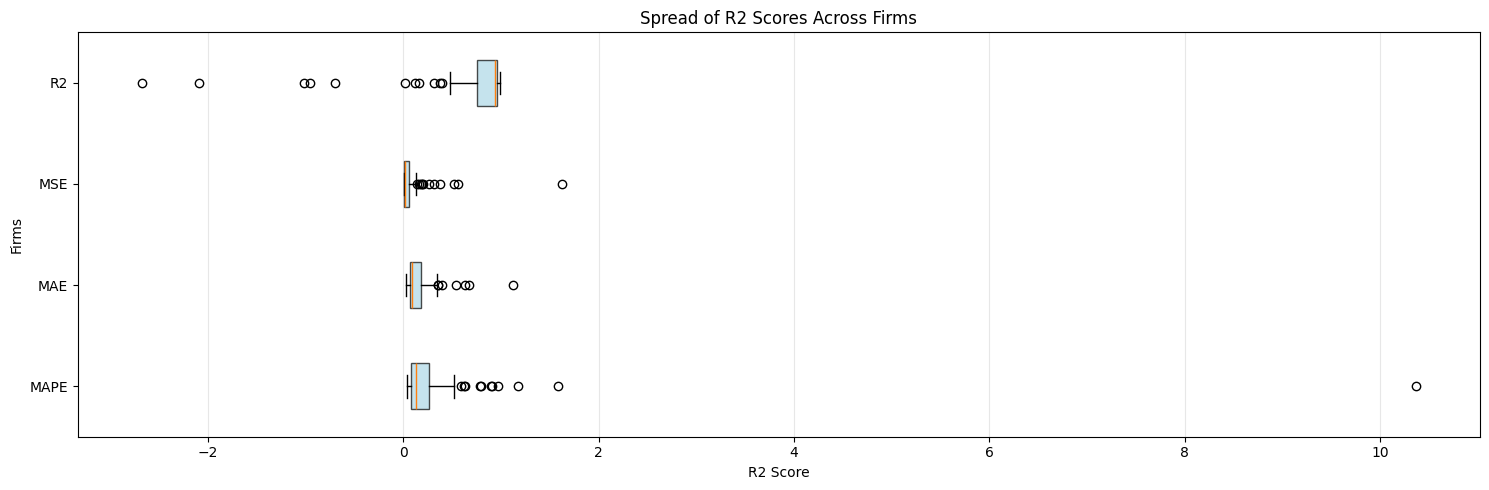

,mean,std,min,25%,median,75%,max,count,nan_count
MAPE,0.345446,1.090633,0.036496,0.078869,0.133409,0.264837,10.370288,92.0,0.0
MAE,0.148598,0.159430,0.026666,0.062815,0.088773,0.176373,1.124855,92.0,0.0
MSE,0.071176,0.191221,0.001159,0.006855,0.017022,0.055881,1.626661,92.0,0.0
R2,0.715506,0.597677,-2.680891,0.753126,0.932920,0.959904,0.989455,92.0,0.0


In [17]:
# getting the performance
filepath = f'results/model performance {experiment_no}.pkl'
with open(filepath, 'rb') as f:
    results_df = pickle.load(f)

# plotting
plt.figure(figsize=(15, 5))
data = [results_df[col].dropna() for col in results_df.columns]
labels = results_df.columns
bp = plt.boxplot(data, vert=False, tick_labels=labels, patch_artist=True)

for box in bp['boxes']:
    box.set_facecolor('lightblue')
    box.set_alpha(0.7)

plt.title('Spread of R2 Scores Across Firms')
plt.xlabel('R2 Score')
plt.ylabel('Firms')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# table of results
results_df = describe_all_columns(results_df)
display(results_df)

Based on the boxplot above, the performance of the model across different was relatively good.
However, for many firms, we need to fine tune the model even more to make it fit better and for better predictions.

## Predictions

In [18]:
filepath = f'results/model predictions {experiment_no}.pkl'
with open(filepath, 'rb') as f:
    all_predictions = pickle.load(f)

for firm in standardized_df.columns:
    # get true and predicted values
    y_true = standardized_df[firm][-len(all_predictions[firm]):]
    y_pred = all_predictions[firm].set_axis(y_true.index)

    # plot the values
    plt.figure(figsize=(15, 3))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(
        f'True vs Predicted Values for {firm}'
    )
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/{firm} prediction vs actual.png')
    plt.close()

In [19]:
np.random.seed(42)
random_firms = np.random.choice(standardized_df.columns.to_list(), 3)
print(
    f'The following firms were chosen: {random_firms}'
)

The following firms were chosen: ['BG' 'AMP' 'MDT']


<div align="center">
<img src='figures/EXE prediction vs actual.png' />
</div>

<div align="center">
<img src='figures/BRO prediction vs actual.png' />
</div>

<div align="center">
<img src='figures/PPL prediction vs actual.png' />
</div>

Based on the randomly selected stocks, the neural network still requires a lot of work.
It seems to be underfitting for a lot of firms, so to improve this, it requires more tuning for the number of hyperparameters of the model.

## Conclusion

After multiple rounds of trial and error with my LSTM neural network, I learned the following: 
1. predicting standardized data works better than predicting log returns;
2. the hidden layer size should not match the lookback window and is more effective when kept at most around half of it;
3. increasing the number of epochs can improve model fit but comes with diminishing returns due to higher computational cost;
4. it is more effective to build a separate model for each firm rather than a single model for all firms;
5. and adding more layers in a neural network makes it more hungry for data. 

In practice, I found that adding more layers and more data did not necessarily improve performance.
A single-layer model outperformed deeper architectures, with Experiment 2 producing better results than Experiment 3.
When implementing a neural network, you have to understand the data you are dealing with, its complexity, and analyze whether more layers would be able to make the data predict more effectively.